In [28]:
from config import settings
from hannover_pylon.data import datamodules as dm
from pathlib import Path
from hannover_pylon.modelling.backbone.utils import FromBuffer , CutPSD, NormLayer
import matplotlib.pyplot as plt
from torch import nn 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
import pandas as pd 
import sqlite3
db_path = Path(settings.path.processed,'Welch(n_fft=16392, fs=1651, max_freq=825.5).db')
conn = sqlite3.connect(db_path)
# Read the 'meteo_data' table into a DataFrame
data_meteo = pd.read_sql('SELECT * FROM meteo_data', conn)
df_plot_meteo = data_meteo.pivot_table(index='date', columns='channel_name', values='value')
df_plot_meteo.index = pd.to_datetime(df_plot_meteo.index)
# Close the database connection
conn.close()

In [30]:
import numpy as np
from pathlib import Path
from torch import nn
freq_axis = np.linspace(0, 825.5, 8197)
columns= ['psd','level','direction']
transform_func = [nn.Sequential(FromBuffer(),CutPSD(freq_axis=freq_axis,freq_range=(0,150)),NormLayer(min_val=-5.46,max_val=4.96))] + [nn.Identity()]*2
query_key = f'''
    SELECT id FROM data
    WHERE date BETWEEN "{settings.state.healthy_train.start}" AND "{settings.state.healthy_train.end}"
    AND corrupted = 0
    AND sensor = "accel"
'''
data_loader = dm.PSDDataModule(db_path= db_path,table_name='data', columns=columns,transform_func=transform_func, query_key=query_key, batch_size=128, return_dict=True, cached=True,num_workers=16)


In [31]:
data_loader.setup()

In [32]:
for batch in data_loader.train_dataloader():
    break

In [33]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
from hannover_pylon.modelling.backbone import utils as ut

class OneToOneAutoEncoder(nn.Module):
    def __init__(self, psd_length=1490, hidden_dims=[512, 128, 64], latent_dim=32, num_classes=10):
        """
        A one-to-one autoencoder for a single sensor with two auxiliary branches for location.
        
        The first branch (regressor) outputs a continuous location estimate (to be compared with MSE).
        The second branch (classifier) outputs logits for discrete location classes.
        
        Args:
            psd_length (int): Length of the PSD vector.
            hidden_dims (list): Hidden layer sizes.
            latent_dim (int): Dimension of the latent space.
            num_classes (int): Number of discrete location classes.
        """
        super().__init__()
        # Encoder: PSD -> hidden layers -> latent vector.
        self.encoder = ut.build_layers(
            hidden_dims=[psd_length] + hidden_dims,
            activation_list=['relu'] * len(hidden_dims) + [None],
            batch_norm=False,
        )
        self.latent_layer = nn.Linear(hidden_dims[-1], latent_dim)
        
        # Decoder: latent vector -> hidden layers (reverse order) -> reconstruction of PSD.
        decoder_dims = hidden_dims[::-1]
        self.decoder = ut.build_layers(
            hidden_dims=[latent_dim] + decoder_dims + [psd_length],
            activation_list=['relu'] * (len(decoder_dims)) + ['sigmoid'],
            batch_norm=False,
        )
        
        # Auxiliary regressor for location prediction (continuous).
        self.location_regressor = nn.Sequential(
            nn.Linear(latent_dim, 1),

        )
        
        # Auxiliary classifier for location prediction (discrete).
        self.location_classifier = nn.Sequential(
            nn.Linear(latent_dim, latent_dim),
            nn.ReLU(),
            nn.Linear(latent_dim, num_classes)
        )
        
        self.device_ = None

    def forward(self, x_dict):
        """
        Args:
            x_dict (dict): Contains:
                - "psd": input tensor of shape (B, psd_length)
                - "location": (optional) target location (for auxiliary loss)
        Returns:
            dict: with keys:
                - "reconstruction": reconstructed PSD vector (B, psd_length)
                - "latent": latent vector (B, latent_dim)
                - "level_pred_reg": output of the regressor branch (B, 1)
                - "level_pred_class": logits from the classifier branch (B, num_classes)
        """
        x = x_dict["psd"]
        if self.device_ is None:
            self.device_ = next(self.parameters()).device
        x = x.to(self.device_)
        encoded = self.encoder(x)
        latent = self.latent_layer(encoded)
        reconstruction = self.decoder(latent)
        level_pred_reg = self.location_regressor(latent)
        level_pred_class = self.location_classifier(latent)
        return {
            "reconstruction": reconstruction,
            "latent": latent,
            "level_pred_reg": level_pred_reg,
            "level_pred_class": level_pred_class
        }

class OneToOneTrainingModule(pl.LightningModule):
    def __init__(self, psd_length=1490, hidden_dims=[512,128,64], latent_dim=32, 
                 num_classes=10, lr=1e-3, lambda_loc=1e-3, lambda_class=1e-3, total_epochs=150):
        """
        Lightning module that trains the autoencoder with two auxiliary branches.
        
        Loss = Reconstruction loss + alpha(epoch)*Regression loss + beta*Classification loss
        
        Args:
            psd_length (int): Length of the PSD vector.
            hidden_dims (list): Hidden layer sizes.
            latent_dim (int): Latent space dimension.
            num_classes (int): Number of discrete location classes.
            lr (float): Learning rate.
            lambda_loc (float): Initial weight for the regression loss.
            lambda_class (float): Constant weight for the classification loss.
            total_epochs (int): Total number of training epochs.
        """
        super().__init__()
        self.model = OneToOneAutoEncoder(psd_length=psd_length, hidden_dims=hidden_dims, 
                                          latent_dim=latent_dim, num_classes=num_classes)
        self.recon_loss_fn = nn.MSELoss()
        self.reg_loss_fn = nn.MSELoss()
        self.class_loss_fn = nn.CrossEntropyLoss()
        self.lr = lr
        self.total_epochs = total_epochs
        self.lambda_loc = lambda_loc
        self.lambda_class = lambda_class
        self.save_hyperparameters(ignore="model")
        
    def forward(self, x):
        return self.model(x)
    
    def lambda_schedule(self, epoch): 
        # Gradually increase the weight of the regression loss so that initially it is lambda_loc 
        # and by the end, its weight is closer to 1.
        prct_progress = epoch / self.total_epochs
        return (10 - 9 * prct_progress) * self.lambda_loc
        
    def _common_step(self, batch, batch_idx):
        output = self(batch)
        reconstruction = output["reconstruction"]
        
        # Regression branch.
        pred_reg = output["level_pred_reg"]  # shape: (B, 1)
        target_level_reg = batch["level"].unsqueeze(1).float()  # shape: (B,1)
        loss_reg = self.reg_loss_fn(pred_reg, target_level_reg)
        
        # Classification branch.
        pred_class = output["level_pred_class"]  # shape: (B, num_classes)
        # Ensure target is of shape (B,) and type Long.
        target_level_class = batch["level"].long()
        loss_class = self.class_loss_fn(pred_class, target_level_class)
        
        loss_recon = self.recon_loss_fn(reconstruction, batch["psd"])
        
        # Get current weight for regression loss.
        alpha = self.lambda_schedule(self.current_epoch)
        total_loss = loss_recon + alpha * loss_reg + self.lambda_class * loss_class
        
        return {
            "total_loss": total_loss, 
            "loss_recon": loss_recon, 
            "loss_reg": loss_reg, 
            "loss_class": loss_class, 
            "alpha": alpha
        }
    
    def training_step(self, batch, batch_idx):
        losses = self._common_step(batch, batch_idx)
        self.log("train_loss", losses["total_loss"], prog_bar=True)
        self.log("train_recon_loss", losses["loss_recon"], prog_bar=True)
        self.log("train_reg_loss", losses["loss_reg"], prog_bar=True)
        self.log("train_class_loss", losses["loss_class"], prog_bar=True)
        self.log("alpha", losses["alpha"], prog_bar=True)
        return losses["total_loss"]
    
    def validation_step(self, batch, batch_idx):
        losses = self._common_step(batch, batch_idx)
        self.log("val_loss", losses["total_loss"], prog_bar=True)
        self.log("val_recon_loss", losses["loss_recon"], prog_bar=True)
        self.log("val_reg_loss", losses["loss_reg"], prog_bar=True)
        self.log("val_class_loss", losses["loss_class"], prog_bar=True)
        self.log("alpha", losses["alpha"], prog_bar=True)
        return losses["total_loss"]
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

# Example usage:
model = OneToOneTrainingModule(
    psd_length=1490,
    hidden_dims=[512,256,128],
    latent_dim=4,
    num_classes=10,   # Set according to your number of discrete location classes.
    lr=1e-3,
    lambda_loc=1e-3,
    lambda_class=1e-3,
    total_epochs=150
)
print(model)


OneToOneTrainingModule(
  (model): OneToOneAutoEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=1490, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=256, bias=True)
      (3): ReLU()
      (4): Linear(in_features=256, out_features=128, bias=True)
      (5): ReLU()
    )
    (latent_layer): Linear(in_features=128, out_features=4, bias=True)
    (decoder): Sequential(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=256, bias=True)
      (3): ReLU()
      (4): Linear(in_features=256, out_features=512, bias=True)
      (5): ReLU()
      (6): Linear(in_features=512, out_features=1490, bias=True)
      (7): Sigmoid()
    )
    (location_regressor): Sequential(
      (0): Linear(in_features=4, out_features=1, bias=True)
    )
    (location_classifier): Sequential(
      (0): Linear(in_features=4, out_features=4, bias=True)
      (1): ReLU()
      (2)

In [34]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import torch

# Instantiate your Lightning module.
model = OneToOneTrainingModule(
    psd_length=1490,
    hidden_dims=[512,256,128,64],
    latent_dim=4,
    lr=1e-3,
    lambda_loc=2e-4
)


# Define a model checkpoint callback to save the best models.
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',              # Monitor the validation loss.
    dirpath='checkpoints',           # Directory to save checkpoints.
    filename='autoencoder-{epoch:02d}-{val_loss:.4f}', 
    save_top_k=3,                    # Save the 3 best models.
    mode='min'
)

# Define an early stopping callback (optional).
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=True,
    mode='min'
)

# Create the Trainer instance.
trainer = Trainer(
    max_epochs=150,
    callbacks=[checkpoint_callback, early_stop_callback],
    accelerator='gpu'
)

# Start training.
trainer.fit(model,data_loader)



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                | Params | Mode 
--------------------------------------------------------------
0 | model         | OneToOneAutoEncoder | 1.9 M  | train
1 | recon_loss_fn | MSELoss             | 0      | train
2 | reg_loss_fn   | MSELoss             | 0      | train
3 | class_loss_fn | CrossEntropyLoss    | 0      | train
--------------------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.495     Total estimated model params size (MB)
22        Modules in train mode
2         Modules in

DataModule already setup
Epoch 0: 100%|██████████| 986/986 [00:07<00:00, 129.19it/s, v_num=197, train_loss=0.00583, train_recon_loss=0.00119, train_reg_loss=1.190, train_class_loss=2.250, alpha=0.002, val_loss=0.00521, val_recon_loss=0.00122, val_reg_loss=0.871, val_class_loss=2.250]

Metric val_loss improved. New best score: 0.005


Epoch 1: 100%|██████████| 986/986 [00:08<00:00, 115.30it/s, v_num=197, train_loss=0.00485, train_recon_loss=0.00133, train_reg_loss=0.723, train_class_loss=2.090, alpha=0.00199, val_loss=0.00459, val_recon_loss=0.00113, val_reg_loss=0.699, val_class_loss=2.070] 

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.005


Epoch 2: 100%|██████████| 986/986 [00:08<00:00, 114.80it/s, v_num=197, train_loss=0.00376, train_recon_loss=0.00114, train_reg_loss=0.516, train_class_loss=1.600, alpha=0.00198, val_loss=0.00402, val_recon_loss=0.00123, val_reg_loss=0.575, val_class_loss=1.650] 

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.004


Epoch 3: 100%|██████████| 986/986 [00:08<00:00, 115.94it/s, v_num=197, train_loss=0.00322, train_recon_loss=0.00124, train_reg_loss=0.364, train_class_loss=1.270, alpha=0.00196, val_loss=0.00332, val_recon_loss=0.000861, val_reg_loss=0.547, val_class_loss=1.390]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.003


Epoch 4: 100%|██████████| 986/986 [00:08<00:00, 114.74it/s, v_num=197, train_loss=0.00229, train_recon_loss=0.000714, train_reg_loss=0.313, train_class_loss=0.963, alpha=0.00195, val_loss=0.00254, val_recon_loss=0.000743, val_reg_loss=0.400, val_class_loss=1.010]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.003


Epoch 5: 100%|██████████| 986/986 [00:08<00:00, 119.00it/s, v_num=197, train_loss=0.00189, train_recon_loss=0.00048, train_reg_loss=0.246, train_class_loss=0.934, alpha=0.00194, val_loss=0.00196, val_recon_loss=0.000518, val_reg_loss=0.307, val_class_loss=0.850] 

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.002


Epoch 6: 100%|██████████| 986/986 [00:08<00:00, 119.61it/s, v_num=197, train_loss=0.00164, train_recon_loss=0.000442, train_reg_loss=0.208, train_class_loss=0.797, alpha=0.00193, val_loss=0.00194, val_recon_loss=0.000487, val_reg_loss=0.327, val_class_loss=0.825]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Epoch 7: 100%|██████████| 986/986 [00:08<00:00, 119.41it/s, v_num=197, train_loss=0.00137, train_recon_loss=0.000467, train_reg_loss=0.166, train_class_loss=0.591, alpha=0.00192, val_loss=0.00158, val_recon_loss=0.000441, val_reg_loss=0.268, val_class_loss=0.625]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Epoch 8: 100%|██████████| 986/986 [00:08<00:00, 120.18it/s, v_num=197, train_loss=0.00249, train_recon_loss=0.000347, train_reg_loss=0.559, train_class_loss=1.080, alpha=0.0019, val_loss=0.00137, val_recon_loss=0.000427, val_reg_loss=0.217, val_class_loss=0.529]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 9: 100%|██████████| 986/986 [00:08<00:00, 120.52it/s, v_num=197, train_loss=0.00193, train_recon_loss=0.000429, train_reg_loss=0.421, train_class_loss=0.702, alpha=0.00189, val_loss=0.00126, val_recon_loss=0.000354, val_reg_loss=0.220, val_class_loss=0.491]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 10: 100%|██████████| 986/986 [00:08<00:00, 120.70it/s, v_num=197, train_loss=0.000784, train_recon_loss=0.000324, train_reg_loss=0.0898, train_class_loss=0.292, alpha=0.00188, val_loss=0.0012, val_recon_loss=0.00039, val_reg_loss=0.205, val_class_loss=0.426]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 11: 100%|██████████| 986/986 [00:08<00:00, 116.56it/s, v_num=197, train_loss=0.000528, train_recon_loss=0.000251, train_reg_loss=0.0431, train_class_loss=0.197, alpha=0.00187, val_loss=0.000991, val_recon_loss=0.000323, val_reg_loss=0.166, val_class_loss=0.358]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 14: 100%|██████████| 986/986 [00:08<00:00, 114.12it/s, v_num=197, train_loss=0.000555, train_recon_loss=0.000328, train_reg_loss=0.0496, train_class_loss=0.136, alpha=0.00183, val_loss=0.000948, val_recon_loss=0.000324, val_reg_loss=0.173, val_class_loss=0.306]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 15: 100%|██████████| 986/986 [00:08<00:00, 117.28it/s, v_num=197, train_loss=0.000753, train_recon_loss=0.000338, train_reg_loss=0.0761, train_class_loss=0.276, alpha=0.00182, val_loss=0.000841, val_recon_loss=0.000293, val_reg_loss=0.153, val_class_loss=0.270]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 18: 100%|██████████| 986/986 [00:08<00:00, 114.82it/s, v_num=197, train_loss=0.000457, train_recon_loss=0.000328, train_reg_loss=0.0286, train_class_loss=0.0786, alpha=0.00178, val_loss=0.000657, val_recon_loss=0.000271, val_reg_loss=0.115, val_class_loss=0.181]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 21: 100%|██████████| 986/986 [00:08<00:00, 113.82it/s, v_num=197, train_loss=0.000275, train_recon_loss=0.000204, train_reg_loss=0.0167, train_class_loss=0.0414, alpha=0.00175, val_loss=0.000606, val_recon_loss=0.000253, val_reg_loss=0.119, val_class_loss=0.146]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 24: 100%|██████████| 986/986 [00:08<00:00, 119.14it/s, v_num=197, train_loss=0.000335, train_recon_loss=0.000266, train_reg_loss=0.0247, train_class_loss=0.0268, alpha=0.00171, val_loss=0.00059, val_recon_loss=0.000249, val_reg_loss=0.124, val_class_loss=0.129]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 26: 100%|██████████| 986/986 [00:08<00:00, 117.63it/s, v_num=197, train_loss=0.00061, train_recon_loss=0.000377, train_reg_loss=0.0797, train_class_loss=0.0991, alpha=0.00169, val_loss=0.000584, val_recon_loss=0.000255, val_reg_loss=0.120, val_class_loss=0.126]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 29: 100%|██████████| 986/986 [00:08<00:00, 119.11it/s, v_num=197, train_loss=0.000371, train_recon_loss=0.000246, train_reg_loss=0.0317, train_class_loss=0.0727, alpha=0.00165, val_loss=0.000534, val_recon_loss=0.000267, val_reg_loss=0.098, val_class_loss=0.105] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 31: 100%|██████████| 986/986 [00:08<00:00, 116.81it/s, v_num=197, train_loss=0.000264, train_recon_loss=0.00022, train_reg_loss=0.0187, train_class_loss=0.0137, alpha=0.00163, val_loss=0.000528, val_recon_loss=0.000227, val_reg_loss=0.110, val_class_loss=0.121]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 33: 100%|██████████| 986/986 [00:08<00:00, 121.13it/s, v_num=197, train_loss=0.00037, train_recon_loss=0.000213, train_reg_loss=0.0574, train_class_loss=0.065, alpha=0.0016, val_loss=0.000485, val_recon_loss=0.00023, val_reg_loss=0.101, val_class_loss=0.0928]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 37: 100%|██████████| 986/986 [00:08<00:00, 118.77it/s, v_num=197, train_loss=0.00103, train_recon_loss=0.000265, train_reg_loss=0.208, train_class_loss=0.437, alpha=0.00156, val_loss=0.000468, val_recon_loss=0.00022, val_reg_loss=0.107, val_class_loss=0.0815]    

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 38: 100%|██████████| 986/986 [00:08<00:00, 120.65it/s, v_num=197, train_loss=0.000237, train_recon_loss=0.000213, train_reg_loss=0.00746, train_class_loss=0.0128, alpha=0.00154, val_loss=0.000432, val_recon_loss=0.000213, val_reg_loss=0.0891, val_class_loss=0.0816]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 39: 100%|██████████| 986/986 [00:08<00:00, 118.81it/s, v_num=197, train_loss=0.000205, train_recon_loss=0.00018, train_reg_loss=0.00943, train_class_loss=0.011, alpha=0.00153, val_loss=0.000427, val_recon_loss=0.00022, val_reg_loss=0.0815, val_class_loss=0.0824]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 40: 100%|██████████| 986/986 [00:08<00:00, 117.50it/s, v_num=197, train_loss=0.00026, train_recon_loss=0.000229, train_reg_loss=0.0092, train_class_loss=0.0173, alpha=0.00152, val_loss=0.000417, val_recon_loss=0.000214, val_reg_loss=0.0855, val_class_loss=0.0731] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 43: 100%|██████████| 986/986 [00:08<00:00, 118.32it/s, v_num=197, train_loss=0.000302, train_recon_loss=0.000227, train_reg_loss=0.0147, train_class_loss=0.0531, alpha=0.00148, val_loss=0.000389, val_recon_loss=0.000214, val_reg_loss=0.0718, val_class_loss=0.0681]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 49: 100%|██████████| 986/986 [00:08<00:00, 119.64it/s, v_num=197, train_loss=0.000267, train_recon_loss=0.000243, train_reg_loss=0.0101, train_class_loss=0.00916, alpha=0.00141, val_loss=0.000383, val_recon_loss=0.000208, val_reg_loss=0.0759, val_class_loss=0.0685] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 53: 100%|██████████| 986/986 [00:12<00:00, 76.89it/s, v_num=197, train_loss=0.000231, train_recon_loss=0.000188, train_reg_loss=0.0137, train_class_loss=0.0245, alpha=0.00136, val_loss=0.000376, val_recon_loss=0.000211, val_reg_loss=0.0743, val_class_loss=0.0631]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 56: 100%|██████████| 986/986 [00:08<00:00, 116.06it/s, v_num=197, train_loss=0.000177, train_recon_loss=0.000164, train_reg_loss=0.00488, train_class_loss=0.00672, alpha=0.00133, val_loss=0.000375, val_recon_loss=0.000197, val_reg_loss=0.0768, val_class_loss=0.0759]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 57: 100%|██████████| 986/986 [00:08<00:00, 114.46it/s, v_num=197, train_loss=0.00021, train_recon_loss=0.000187, train_reg_loss=0.0098, train_class_loss=0.0105, alpha=0.00132, val_loss=0.000349, val_recon_loss=0.000198, val_reg_loss=0.0688, val_class_loss=0.0604]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 64: 100%|██████████| 986/986 [00:08<00:00, 110.03it/s, v_num=197, train_loss=0.000206, train_recon_loss=0.00017, train_reg_loss=0.00779, train_class_loss=0.026, alpha=0.00123, val_loss=0.000347, val_recon_loss=0.000196, val_reg_loss=0.0782, val_class_loss=0.0553]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 65: 100%|██████████| 986/986 [00:09<00:00, 107.70it/s, v_num=197, train_loss=0.000498, train_recon_loss=0.00021, train_reg_loss=0.118, train_class_loss=0.144, alpha=0.00122, val_loss=0.000331, val_recon_loss=0.000193, val_reg_loss=0.0639, val_class_loss=0.0601]     

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 71: 100%|██████████| 986/986 [00:09<00:00, 107.78it/s, v_num=197, train_loss=0.000255, train_recon_loss=0.000177, train_reg_loss=0.018, train_class_loss=0.0573, alpha=0.00115, val_loss=0.000326, val_recon_loss=0.00019, val_reg_loss=0.0688, val_class_loss=0.0571]    

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 76: 100%|██████████| 986/986 [00:09<00:00, 106.86it/s, v_num=197, train_loss=0.000217, train_recon_loss=0.000196, train_reg_loss=0.0108, train_class_loss=0.0097, alpha=0.00109, val_loss=0.000324, val_recon_loss=0.000192, val_reg_loss=0.0684, val_class_loss=0.0582]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 78: 100%|██████████| 986/986 [00:09<00:00, 109.25it/s, v_num=197, train_loss=0.000149, train_recon_loss=0.000138, train_reg_loss=0.00702, train_class_loss=0.00379, alpha=0.00106, val_loss=0.0003, val_recon_loss=0.000187, val_reg_loss=0.0565, val_class_loss=0.0535]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 80: 100%|██████████| 986/986 [00:09<00:00, 108.43it/s, v_num=197, train_loss=0.000179, train_recon_loss=0.00015, train_reg_loss=0.023, train_class_loss=0.00514, alpha=0.00104, val_loss=0.000293, val_recon_loss=0.000186, val_reg_loss=0.0583, val_class_loss=0.0465] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 84: 100%|██████████| 986/986 [00:09<00:00, 107.34it/s, v_num=197, train_loss=0.000174, train_recon_loss=0.000158, train_reg_loss=0.011, train_class_loss=0.00504, alpha=0.000992, val_loss=0.000286, val_recon_loss=0.000183, val_reg_loss=0.0572, val_class_loss=0.0466] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 88: 100%|██████████| 986/986 [00:08<00:00, 110.05it/s, v_num=197, train_loss=0.000212, train_recon_loss=0.000192, train_reg_loss=0.00909, train_class_loss=0.0116, alpha=0.000944, val_loss=0.000274, val_recon_loss=0.00018, val_reg_loss=0.0517, val_class_loss=0.0451]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 98: 100%|██████████| 986/986 [00:08<00:00, 113.11it/s, v_num=197, train_loss=0.000366, train_recon_loss=0.000179, train_reg_loss=0.0579, train_class_loss=0.139, alpha=0.000824, val_loss=0.000443, val_recon_loss=0.000198, val_reg_loss=0.147, val_class_loss=0.123]     

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 98: 100%|██████████| 986/986 [00:08<00:00, 113.09it/s, v_num=197, train_loss=0.000366, train_recon_loss=0.000179, train_reg_loss=0.0579, train_class_loss=0.139, alpha=0.000824, val_loss=0.000443, val_recon_loss=0.000198, val_reg_loss=0.147, val_class_loss=0.123]


In [35]:
best_model_path = checkpoint_callback.best_model_path
# print mse loss
print(checkpoint_callback.best_model_score.item())
best_model = OneToOneTrainingModule.load_from_checkpoint(best_model_path)

0.0002740746713243425


In [36]:
best_model

OneToOneTrainingModule(
  (model): OneToOneAutoEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=1490, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=256, bias=True)
      (3): ReLU()
      (4): Linear(in_features=256, out_features=128, bias=True)
      (5): ReLU()
      (6): Linear(in_features=128, out_features=64, bias=True)
      (7): ReLU()
    )
    (latent_layer): Linear(in_features=64, out_features=4, bias=True)
    (decoder): Sequential(
      (0): Linear(in_features=4, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=256, bias=True)
      (5): ReLU()
      (6): Linear(in_features=256, out_features=512, bias=True)
      (7): ReLU()
      (8): Linear(in_features=512, out_features=1490, bias=True)
      (9): Sigmoid()
    )
    (location_regressor): Sequential(
      (0): Linear(in_features=4,

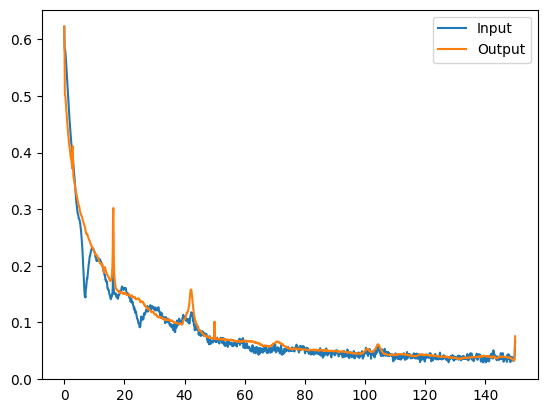

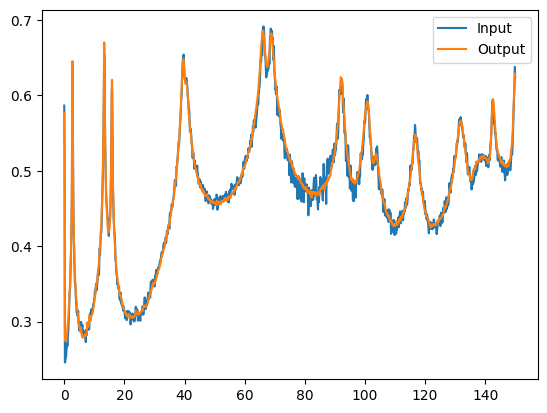

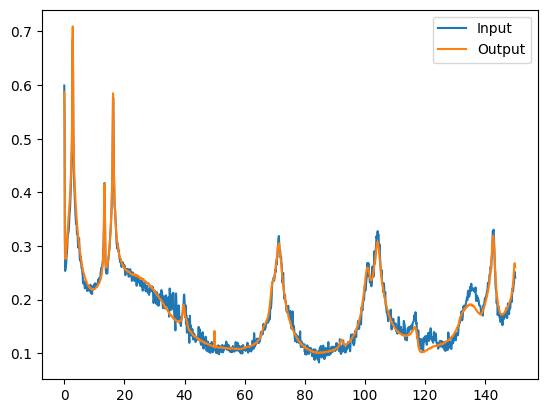

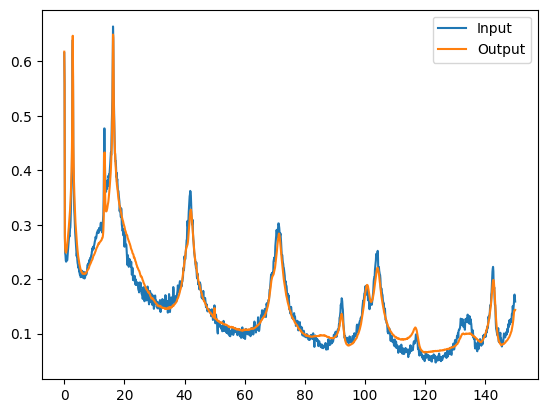

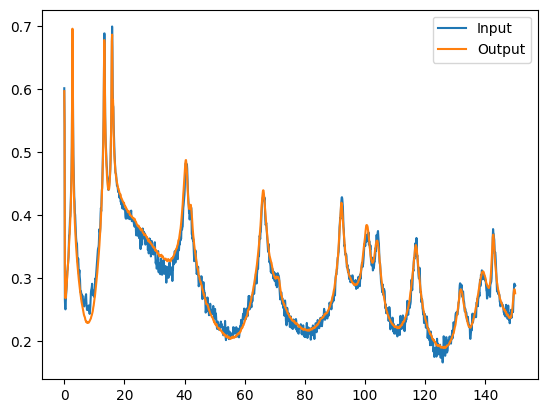

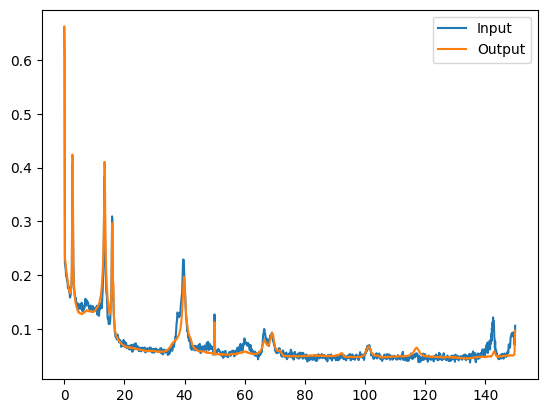

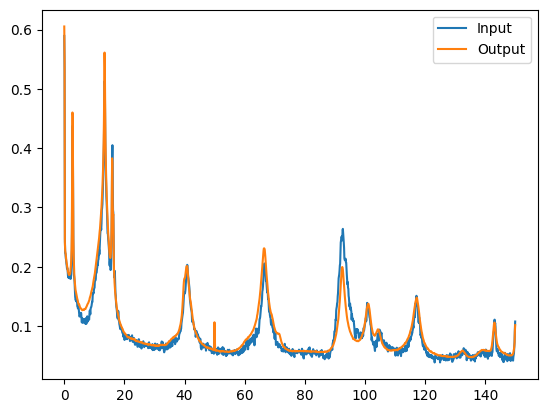

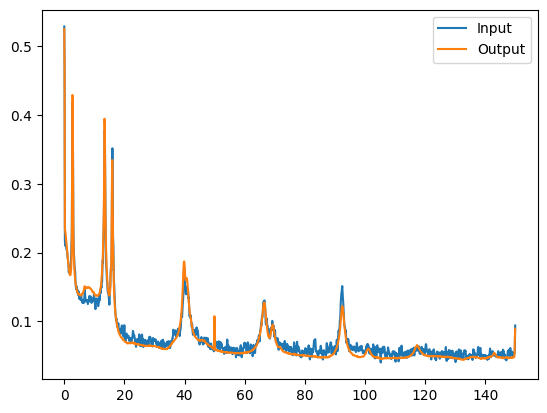

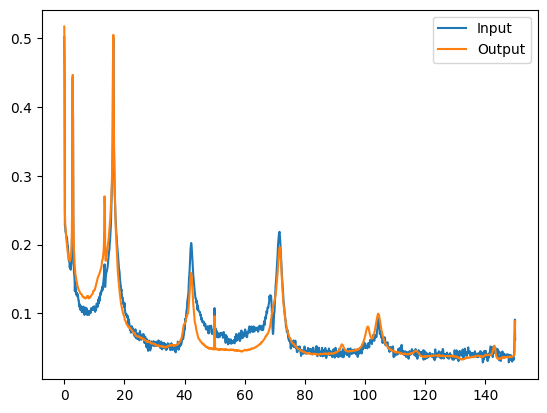

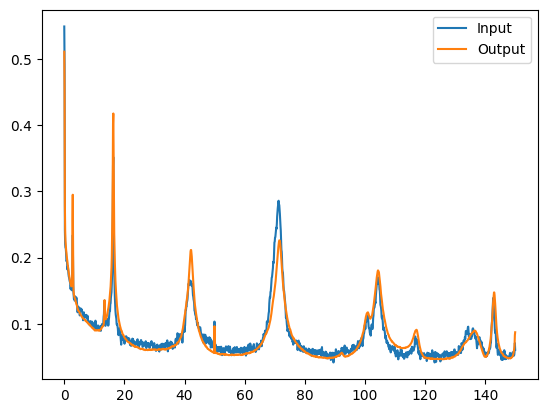

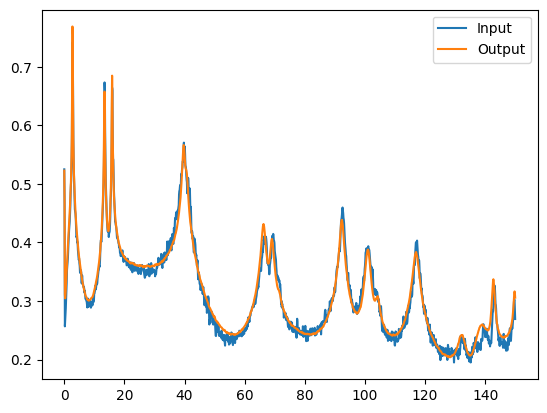

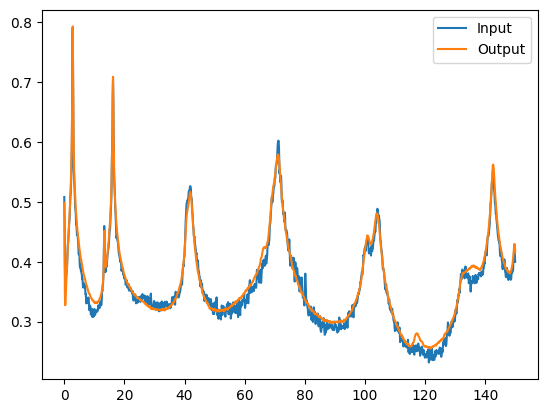

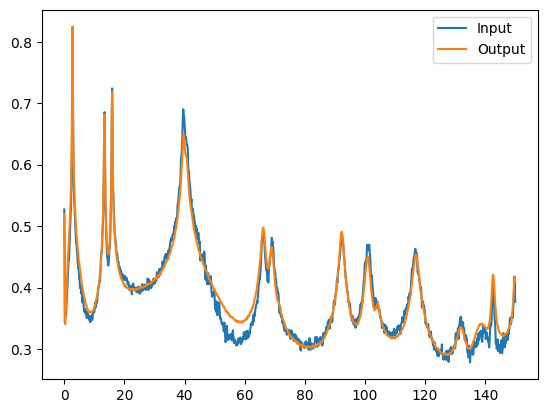

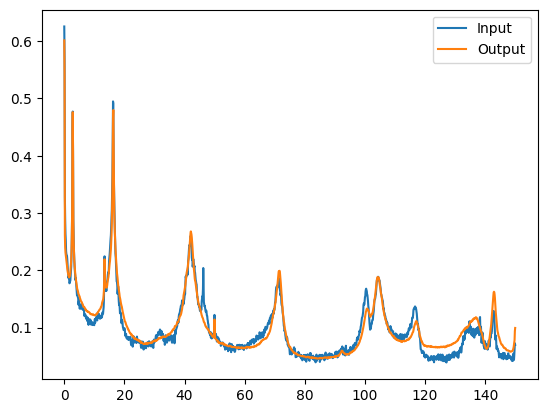

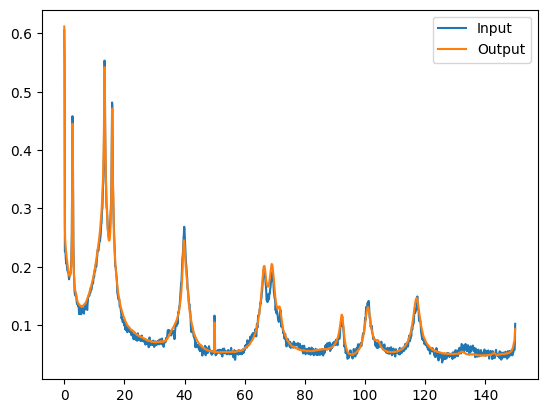

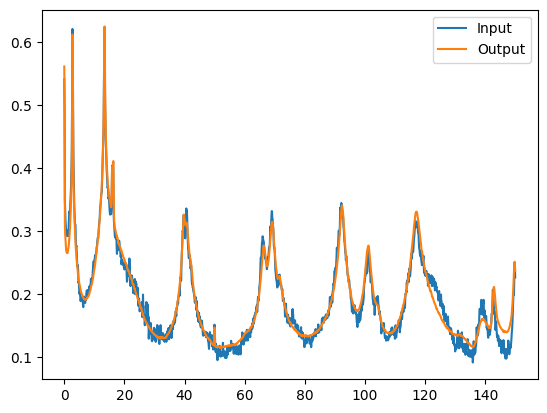

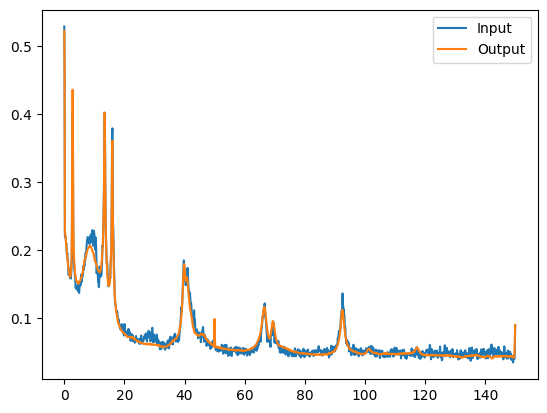

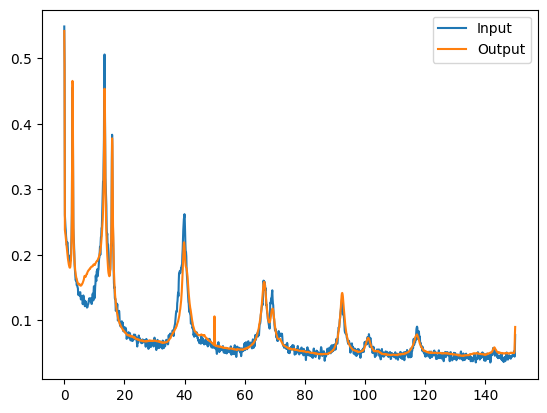

In [37]:
best_model.eval()
batch = next(iter(data_loader.val_dataloader()))
psd_out = best_model(batch)
psd_in = batch['psd']
psd_out = psd_out['reconstruction']                                        

for i in range(18):
    plt.figure()
    plt.plot(freq_axis[0:1490], psd_in[i].detach().numpy(), label='Input')
    plt.plot(freq_axis[0:1490], psd_out[i].cpu().detach().numpy(), label='Output')
    plt.legend()
    plt.show()
    plt.close()

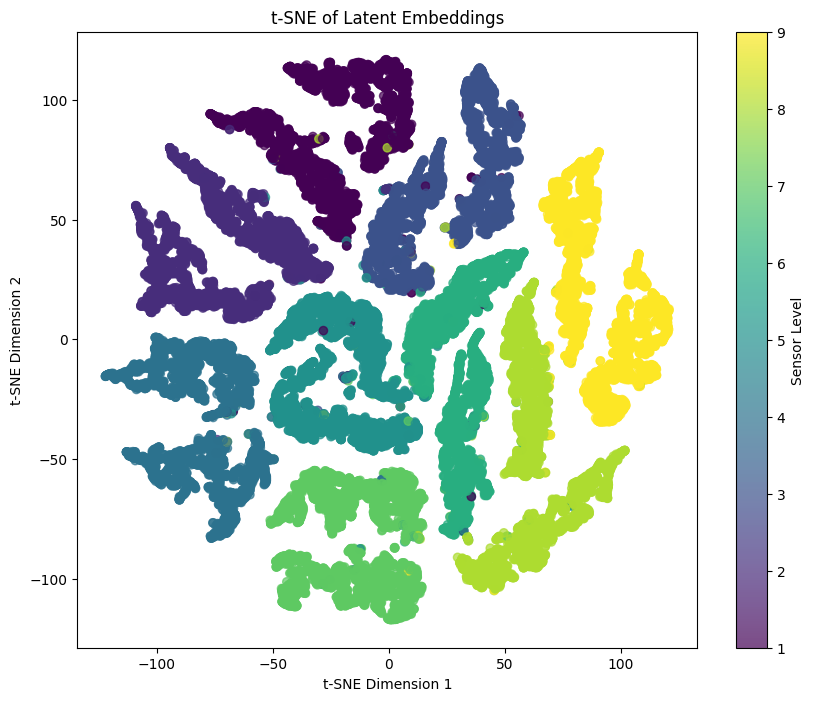

In [38]:
import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Set the model to evaluation mode.
best_model.eval()

all_latent = []
all_labels = []  # We'll assume the sensor level is stored in batch["level"]

# Loop over the entire validation dataloader.
for batch in data_loader.val_dataloader():
    with torch.no_grad():
        # Forward pass through the model to get latent embeddings.
        out = best_model(batch)
        latent = out["latent"]  # shape: (B, latent_dim)
    all_latent.append(latent.cpu().numpy())
    # Collect the true sensor levels; ensure they are in numpy format.
    labels = batch["level"].cpu().numpy()  
    all_labels.append(labels)

# Concatenate the results.
all_latent = np.concatenate(all_latent, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Apply t-SNE to reduce to 2 dimensions.
tsne = TSNE(n_components=2, random_state=42)
latent_tsne = tsne.fit_transform(all_latent)

# Plot the t-SNE embedding.
plt.figure(figsize=(10, 8))
scatter = plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=all_labels, cmap="viridis", alpha=0.7)
plt.colorbar(scatter, label="Sensor Level")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("t-SNE of Latent Embeddings")
plt.show()


In [39]:
import torch
import torch.nn as nn

class Detector(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.model.eval()  # Set the model to evaluation mode
        self.device = next(model.parameters()).device

    def mse(self, x_dict):
        with torch.no_grad():
            out = self.model(x_dict)
        # Compute reconstruction error (90th percentile)
        error = (x_dict["psd"].to(self.device) - out["reconstruction"].to(self.device)) ** 2
        quantile_error = torch.quantile(error, q=0.9, dim=1)
        
        # Extract the predicted mean and log variance from the auxiliary branch.
        pred = out["level_pred_reg"]
        loc_err = (x_dict["level"].to(self.device) - pred) 


        
        res = {
            "quantile_error": quantile_error.cpu().numpy().squeeze(),
            "location_mean": pred.cpu().numpy().squeeze(),
        }
        res['location_error'] = res['location_mean'] - x_dict['level'].cpu().numpy().squeeze()
        # Return the monitored quantities.
        return res

    def forward(self, x_dict):
        return self.mse(x_dict)


In [40]:
best_model.to('cuda')
detector = Detector(best_model)

# Get a batch from your data loader (which yields a dict with key "psd").
batch = next(iter(data_loader.val_dataloader()))

# Compute the damage metric for this batch.
damage_metric = detector(batch)  # returns a tensor of shape (B,)

print("Damage metric (90th percentile reconstruction error) per sample:")
print(damage_metric)

Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 731, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 729, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-kmj4iapd'


Damage metric (90th percentile reconstruction error) per sample:
{'quantile_error': array([3.67938279e-04, 2.02413619e-04, 4.00549587e-04, 7.59428600e-04,
       3.47676832e-04, 2.13928040e-04, 5.61121502e-04, 1.80493778e-04,
       8.07246135e-04, 3.69548361e-04, 4.52659151e-04, 3.87412991e-04,
       8.02089984e-04, 5.43455069e-04, 1.71661522e-04, 5.54275874e-04,
       1.14671398e-04, 2.36702836e-04, 3.87569773e-04, 2.73314829e-04,
       1.83323020e-04, 4.30912478e-04, 5.01189097e-05, 6.71500384e-05,
       9.31713323e-04, 4.03558224e-04, 3.58520134e-04, 1.63560588e-04,
       1.30067361e-04, 6.73783943e-04, 2.17779569e-04, 8.43267262e-05,
       2.89452524e-04, 3.93070368e-04, 1.31221168e-04, 1.89730359e-04,
       1.57301823e-04, 6.72204536e-04, 1.59347459e-04, 2.78925028e-04,
       1.94906082e-04, 2.04606156e-04, 1.46943217e-04, 6.46666915e-04,
       1.37513783e-03, 1.74715853e-04, 1.51415216e-03, 4.11202520e-04,
       7.08332154e-05, 6.95349954e-05, 1.17629075e-04, 3.4521456

In [41]:
freq_axis = np.linspace(0, 825.5, 8197)
db_path = Path(settings.path.processed,'Welch(n_fft=16392, fs=1651, max_freq=825.5).db')
columns= ['psd','direction','level','date']
transform_func = [nn.Sequential(FromBuffer(),CutPSD(freq_axis=freq_axis,freq_range=(0,150)),NormLayer(min_val=-5.46,max_val=4.96))] + [nn.Identity()]*3
query_key = f'''
    SELECT id FROM data
    WHERE sensor = "accel"
    AND corrupted = 0
'''
data_loader = dm.PSDDataModule(db_path= db_path,table_name='data',
                               columns=columns,transform_func=transform_func,
                               query_key=query_key, batch_size=10000, return_dict=True, cached=False)
data_loader.setup()


In [42]:
import pandas as pd
import torch

def to_numpy(x):
    """
    Converts a tensor to a NumPy array if needed,
    otherwise returns x unchanged.
    """
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy().ravel()
    return x

df_list = []

# Iterate over all batches from the data loader
for batch in data_loader.all_dataloader():
    # 1. Run the detector (returns a dict of tensors)
    with torch.no_grad():
        metrics = detector(batch)  # e.g. {'metric1': ..., 'metric2': ...}

    batch.update(metrics)
    batch = {k: to_numpy(v) for k, v in batch.items()}
    batch.pop('psd')


    # 4. Create a DataFrame for the current batch
    df_list.append(pd.DataFrame(batch))

# 5. Concatenate all the batch DataFrames
df_res = pd.concat(df_list, ignore_index=True)

print(df_res.head())


  direction  level                 date  quantile_error  location_mean  \
0         x      1  2020-08-01 00:02:00        0.000123       1.095983   
1         y      1  2020-08-01 00:02:00        0.000224       0.987229   
2         x      2  2020-08-01 00:02:00        0.000231       2.033243   
3         y      2  2020-08-01 00:02:00        0.000250       1.954885   
4         x      3  2020-08-01 00:02:00        0.000103       3.036266   

   location_error  
0        0.095983  
1       -0.012771  
2        0.033243  
3       -0.045115  
4        0.036266  


In [43]:
df_res

,direction,level,date,quantile_error,location_mean,location_error
0,x,1,2020-08-01 00:02:00,0.000123,1.095983,0.095983
1,y,1,2020-08-01 00:02:00,0.000224,0.987229,-0.012771
2,x,2,2020-08-01 00:02:00,0.000231,2.033243,0.033243
3,y,2,2020-08-01 00:02:00,0.000250,1.954885,-0.045115
4,x,3,2020-08-01 00:02:00,0.000103,3.036266,0.036266
...,...,...,...,...,...,...
918895,y,7,2021-07-31 23:56:00,0.000304,6.996968,-0.003032
918896,x,8,2021-07-31 23:56:00,0.000294,8.022514,0.022514
918897,y,8,2021-07-31 23:56:00,0.000360,7.927005,-0.072995
918898,x,9,2021-07-31 23:56:00,0.000277,8.751944,-0.248056


In [44]:
col_of_interest = 'location_error'


# Convert the date column to datetime.
df_res['date'] = pd.to_datetime(df_res['date'])
# Define training period boundaries using your settings.
train_start = pd.to_datetime(settings.state.healthy_train.start)
train_end   = pd.to_datetime(settings.state.healthy_train.end)

def normalize_sensor(group):
    """
    For a given sensor group, normalize the 'mse' column using the training period's min and max.
    """
    # Create a mask for rows within the training period.
    train_mask = (group['date'] >= train_start) & (group['date'] <= train_end)
    
    if train_mask.any():
        train_min = group.loc[train_mask, col_of_interest].quantile(0.01)
        train_max = group.loc[train_mask, col_of_interest].quantile(0.98)
        if train_max - train_min != 0:
            
            group[col_of_interest] = -(group[col_of_interest] - train_min) / (train_max - train_min)
        else:
            group[col_of_interest] = 0.0  # Avoid division by zero.
    else:
        # If no training data is available for this sensor group, you can decide to leave it as is or set to NaN.
        group[col_of_interest] = group[col_of_interest]  # or: group['mse'] = np.nan
    return group

# Group the DataFrame by sensor. Here, we assume that 'direction' indicates the sensor.
df_normalized = df_res.groupby('direction', group_keys=False).apply(normalize_sensor)

# Display the first few rows of the normalized DataFrame.
print(df_normalized.head())


  direction  level                date  quantile_error  location_mean  \
0         x      1 2020-08-01 00:02:00        0.000123       1.095983   
1         y      1 2020-08-01 00:02:00        0.000224       0.987229   
2         x      2 2020-08-01 00:02:00        0.000231       2.033243   
3         y      2 2020-08-01 00:02:00        0.000250       1.954885   
4         x      3 2020-08-01 00:02:00        0.000103       3.036266   

   location_error  
0       -0.801878  
1       -0.686945  
2       -0.639762  
3       -0.618568  
4       -0.647573  


/tmp/ipykernel_47434/1064703131.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_normalized = df_res.groupby('direction', group_keys=False).apply(normalize_sensor)


In [45]:
df_normalized[col_of_interest].quantile(1)

np.float64(20.737428248858798)

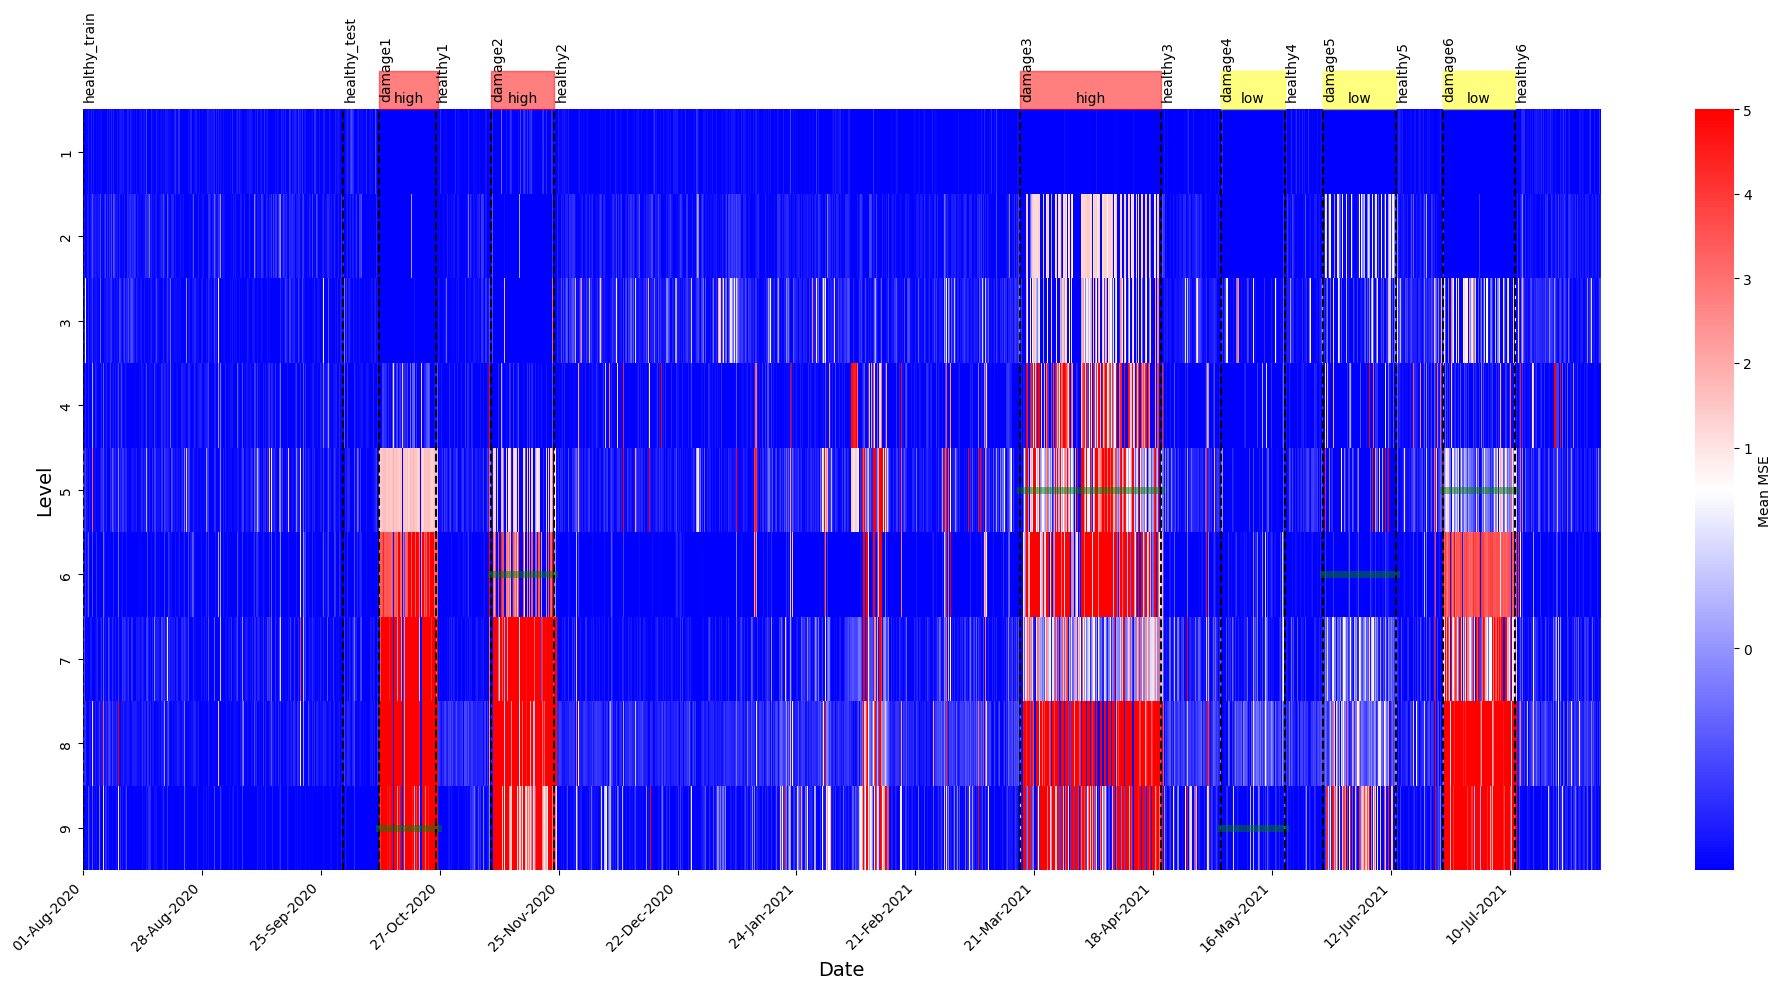

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter, MaxNLocator
from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors
col_of_interest = 'location_error'

# Ensure the date column is in datetime format.
df_normalized['date'] = pd.to_datetime(df_normalized['date'])

# Optionally, select a single sensor direction for the control chart.
# For instance, if you want to focus on the "y" direction:
df_control = df_normalized[df_normalized['direction'] == 'y']

# =============================================================================
# 2. Pivot the DataFrame for a Heatmap
# =============================================================================
# Create a pivot table with sensor level as the index, date as columns, and mean mse as values.
df_pivot = df_control.pivot_table(index='level', columns='date', values=col_of_interest, aggfunc='mean')
#df_pivot = df_pivot.rolling('1h').mean().T
# Ensure the pivot table's columns are datetime objects.
df_pivot.columns = pd.to_datetime(df_pivot.columns)

# =============================================================================
# 3. Create a Custom Date Formatter for the x-axis
# =============================================================================
def create_date_formatter(column_dates):
    """Return a custom formatter function for datetime labels."""
    def custom_date_format(x, pos=None):
        try:
            idx = int(x)
            if 0 <= idx < len(column_dates):
                return column_dates[idx].strftime('%d-%b-%Y')
            return ''
        except Exception:
            return ''
    return FuncFormatter(custom_date_format)

# =============================================================================
# 4. Define Custom Colormap and Norm
# =============================================================================
# Create a custom colormap from blue to white to red.
custom_cmap = mcolors.LinearSegmentedColormap.from_list('custom_bwr', ['blue', 'white', 'red'])
# Use TwoSlopeNorm to center the colormap at 1, with vmin=0 and vmax=2.
norm = mcolors.TwoSlopeNorm(vmin=-0.7, vcenter=0.5, vmax=5)

# =============================================================================
# 5. Plot the Control Chart (Heatmap)
# =============================================================================
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

sns.heatmap(
    df_pivot,
    cmap=custom_cmap,                # Use the custom colormap.
    norm=norm,                       # Apply the normalization so that white is at 1.
    cbar_kws={'label': 'Mean MSE'},   # Label for the color bar.
    ax=ax
)

ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Level', fontsize=14)

# Create a list of dates from the pivot table columns.
dates_list = list(df_pivot.columns)
ax.xaxis.set_major_formatter(create_date_formatter(dates_list))
ax.xaxis.set_major_locator(MaxNLocator(nbins=15))  # Limit the number of x-axis ticks

# Rotate x-axis labels for better readability.
plt.xticks(rotation=45, ha='right')

# =============================================================================
# 6. (Optional) Annotate Events on the Chart
# =============================================================================
# If you have events defined in your settings, you can annotate the plot.
# For example, if events are stored as a dictionary in settings.state:
# events = {
#     "Event1": {"start": "2020-01-10", "end": "2020-01-12", "closest_sensor": 3, "severity": "high"},
#     "Event2": {"start": "2020-02-05", "end": "2020-02-07", "closest_sensor": 2, "severity": "low"}
# }
events = settings.state.to_dict()
for event_i, event_info in events.items():
    start = pd.to_datetime(event_info['start'])
    end = pd.to_datetime(event_info['end'])
    # Find approximate x-axis indices corresponding to start and end dates.
    idx_start = np.searchsorted(df_pivot.columns, start)
    idx_end = np.searchsorted(df_pivot.columns, end)
    
    # Draw a vertical line at the event start.
    ax.axvline(idx_start, color='black', linestyle='--', label=f'{event_i} start')
    ax.text(idx_start, -0.1, f'{event_i}', rotation=90, va='bottom', ha='left')
    
    # Draw a horizontal line at the sensor level closest to the event (if provided).
    level = event_info.get('closest_sensor', None)
    if level is not None:
        ax.axhline(level - 0.5, xmin=idx_start/len(df_pivot.columns), xmax=idx_end/len(df_pivot.columns),
                   color='green', linestyle='-', lw=5, alpha=0.5)
    
    # Draw a rectangle above the plot indicating severity.
    severity = event_info.get('severity', None)
    if severity is not None:
        color = 'red' if severity == 'high' else 'yellow'
        box_height = 0.05  # Height of the severity box.
        ax.add_patch(Rectangle(
            (idx_start, 1),       # Position above the plot.
            width=idx_end - idx_start,
            height=box_height,
            color=color,
            alpha=0.5,
            transform=ax.get_xaxis_transform(),
            clip_on=False
        ))
        ax.text((idx_start + idx_end) / 2, -0.1 + box_height, severity,
                ha='center', va='bottom', color='black')

# =============================================================================
# 7. Finalize and Show the Plot
# =============================================================================
plt.tight_layout()
plt.show()


In [47]:
df_normalized['sensor_name'] = df_normalized['direction'] + df_normalized['level'].astype(str)

In [49]:
df_normalized

,direction,level,date,quantile_error,location_mean,location_error,sensor_name
0,x,1,2020-08-01 00:02:00,0.000123,1.095983,-0.801878,x1
1,y,1,2020-08-01 00:02:00,0.000224,0.987229,-0.686945,y1
2,x,2,2020-08-01 00:02:00,0.000231,2.033243,-0.639762,x2
3,y,2,2020-08-01 00:02:00,0.000250,1.954885,-0.618568,y2
4,x,3,2020-08-01 00:02:00,0.000103,3.036266,-0.647573,x3
...,...,...,...,...,...,...,...
918895,y,7,2021-07-31 23:56:00,0.000304,6.996968,-0.707533,y7
918896,x,8,2021-07-31 23:56:00,0.000294,8.022514,-0.612039,x8
918897,y,8,2021-07-31 23:56:00,0.000360,7.927005,-0.559627,y8
918898,x,9,2021-07-31 23:56:00,0.000277,8.751944,0.087102,x9


In [50]:
import pandas as pd
import numpy as np
from sklearn.covariance import OAS

df_agg= df_normalized[df_normalized['direction']=="y"].pivot(index='date', columns='sensor_name', values='quantile_error') 
df_agg.index = pd.to_datetime(df_agg.index)
train_start = pd.to_datetime(settings.state.healthy_train.start)
train_end = pd.to_datetime(settings.state.healthy_train.end)
train_mask = (df_agg.index >= train_start) & (df_agg.index <= train_end)
df_train = df_agg.loc[train_mask]
oas = OAS(store_precision=True, assume_centered=False)
oas.fit(df_train)
df_agg['mahal'] = np.sqrt(oas.mahalanobis(df_agg))

# --- 6. (Optional) Inspect the Results ---


In [51]:
negative_mask = df_plot_meteo['airTemperatureAt2m'] < 0

start_indices = df_plot_meteo.index[negative_mask & ~negative_mask.shift(fill_value=False)]
end_indices = df_plot_meteo.index[~negative_mask & negative_mask.shift(fill_value=False)]

# Ensure lengths match (handle open-ended cases)
if len(end_indices) < len(start_indices):
    end_indices = end_indices.append(pd.Index([df_plot_meteo.index[-1]]))

# Create a DataFrame with stardf_plot_meteot and end times of subzero temperature regions
date_subzero_temperature = pd.DataFrame({'start_time': start_indices, 'end_time': end_indices})


In [52]:
sensor_cols = df_agg.filter(regex=r'^y\d+$').columns
df_agg['mean_mse'] = df_agg[sensor_cols].mean(axis=1)



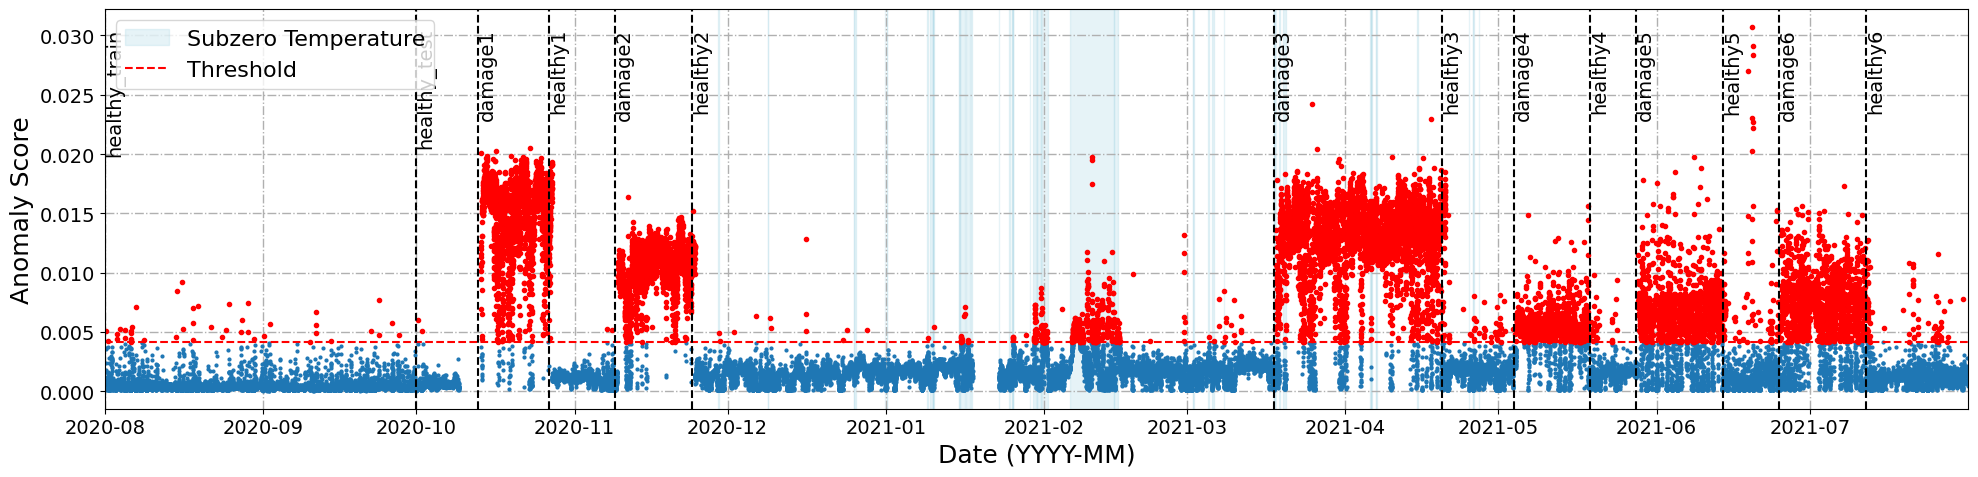

In [53]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ---------------------------
# Update Publication Quality Settings with Increased Fonts
# ---------------------------
plt.rcParams.update({
    'font.size': 14,         # Base font size
    'axes.labelsize': 18,    # X and Y label font size
    'axes.titlesize': 20,    # Axes title font size
    'legend.fontsize': 16,   # Legend font size
    'xtick.labelsize': 14,   # X-tick label size
    'ytick.labelsize': 14,   # Y-tick label size
    'lines.linewidth': 1.5,
    'grid.linestyle': '-.',
    'grid.linewidth': 1,
})

# Define the column of interest (e.g., mean_mse).
col_of_interest = 'mean_mse'

# ---------------------------
# 1. Create Figure and Plot Main Control Chart
# ---------------------------
fig, ax = plt.subplots(figsize=(20, 5))

# Plot anomaly scores as individual points.
ax.plot(
    df_agg.index, 
    df_agg[col_of_interest],
    'o', 
    markersize=2, 
    color='tab:blue', 
)

# Compute threshold (99.5th percentile over the training period).
train_start = pd.to_datetime(settings.state.healthy_train.start)
train_end = pd.to_datetime(settings.state.healthy_train.end)
df_train = df_agg.loc[train_start:train_end]
threshold = df_train[col_of_interest].quantile(0.995)

# Plot the threshold as a horizontal dashed red line.
ax.axhline(threshold, color='red', linestyle='--', label='Threshold')

# Highlight points exceeding the threshold.
exceed_mask = df_agg[col_of_interest] > threshold
ax.plot(
    df_agg.index[exceed_mask],
    df_agg.loc[exceed_mask, col_of_interest],
    'o', 
    markersize=3, 
    color='red',
)

# ---------------------------
# 2. Shade Subzero Temperature Regions
# ---------------------------
# Assume 'date_subzero_temperature' is a DataFrame with 'start_time' and 'end_time' columns.
for _, row in date_subzero_temperature.iterrows():
    ax.axvspan(
        row['start_time'], 
        row['end_time'], 
        color='lightblue', 
        alpha=0.3, 
        zorder=0
    )

# Create a patch for the legend.
subzero_patch = mpatches.Patch(color='lightblue', alpha=0.3, label='Subzero Temperature')

# ---------------------------
# 3. Add Legend and Annotate Events
# ---------------------------
# Combine existing legend handles with the subzero patch.
handles, labels = ax.get_legend_handles_labels()
handles.insert(0, subzero_patch)
labels.insert(0, 'Subzero Temperature')
ax.legend(handles, labels, loc='upper left', frameon=True)

# Annotate events from settings, if any.
for event_i, event_info in settings.state.to_dict().items():
    start = pd.to_datetime(event_info['start'])
    # Draw a vertical dashed line at the event start.
    ax.axvline(start, color='black', linestyle='--', label=f'{event_i} start')
    # Optionally, add text annotation near the top of the plot.
    ax.text(
        start, 
        ax.get_ylim()[1] * 0.95, 
        f'{event_i}', 
        rotation=90, 
        va='top', 
        ha='left'
    )

# ---------------------------
# 4. Final Touches
# ---------------------------
ax.set_xmargin(0)
ax.set_xlabel('Date (YYYY-MM)', fontsize=18)  # Increased label font size
ax.set_ylabel('Anomaly Score', fontsize=18)    # Increased label font size
ax.grid(True)

plt.tight_layout()

# Save the figure at high resolution (300 dpi) for journal publication.
plt.savefig("journal_plot.png", dpi=300)
plt.show()


In [54]:
df_plot_meteo.index = df_plot_meteo.index + pd.Timedelta(minutes=10)   
df_merge_temp = pd.merge_asof(df_agg,df_plot_meteo, 
                            left_index=True, right_index=True, direction='nearest')


In [55]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Example: Focus on level=1 data or a specific label. Adjust as needed.
# (If you already have df_res_level_meteo, skip re-assigning it.)
df_plot = df_merge_temp.copy()

# Drop rows missing MSE or Temperature.
df_plot = df_plot.dropna(subset=['mean_mse', 'airTemperatureAt2m'])


In [56]:
from hannover_pylon.utils.evaluation import label_dataframe_event 
df_plot['label']=label_dataframe_event(df_plot.index,events=settings.state.to_dict())
df_plot['label'].unique()

array(['healthy_train', 'healthy_test', 'damage1', 'healthy1', 'damage2',
       'healthy2', 'damage3', 'healthy3', 'damage4', 'healthy4',
       'damage5', 'healthy5', 'damage6', 'healthy6'], dtype=object)

/tmp/ipykernel_47434/1878487454.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_healthy_2.groupby('temp_bin')


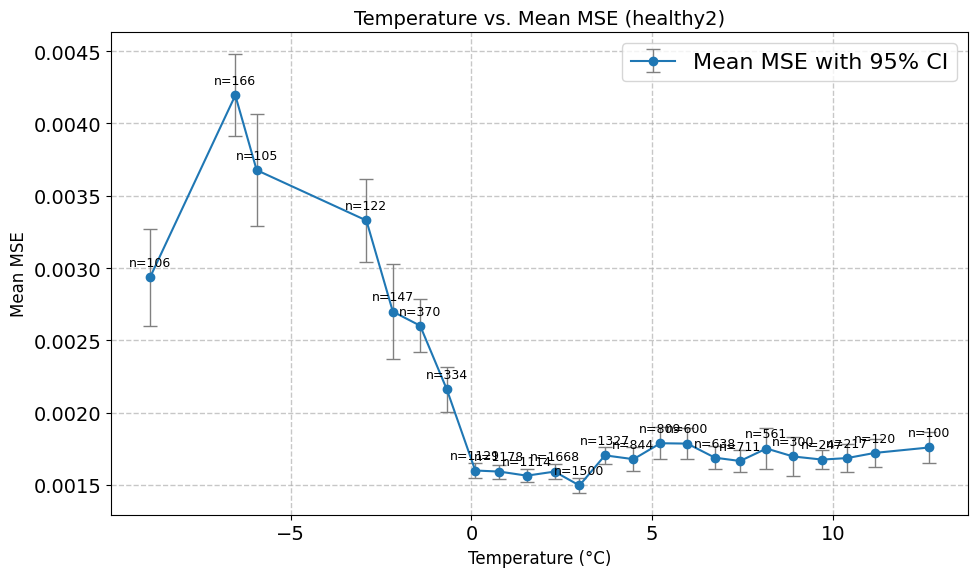

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import t, pearsonr

# Assume df_plot is your merged DataFrame that contains:
# - 'airTemperatureAt2m': temperature readings,
# - 'mean_mse': the 2-hour rolling median of MSE (or your chosen aggregated anomaly score),
# - 'label': event/health label.

# Filter to the desired label (for example, "healthy2")
df_healthy_2 = df_plot[df_plot['label'] == 'healthy2'].copy()

# Create bins for temperature.
# Here we use 50 bins; adjust this number as needed.
df_healthy_2['temp_bin'] = pd.cut(df_healthy_2['airTemperatureAt2m'], bins=50)

# Group by these temperature bins.
grouped = df_healthy_2.groupby('temp_bin')

# Compute aggregated statistics per bin.
mean_temp = grouped['airTemperatureAt2m'].mean()        # Mean temperature in each bin
mean_mse = grouped['mean_mse'].mean()                     # Mean MSE in each bin
std_mse = grouped['mean_mse'].std()                       # Standard deviation of MSE
count_mse = grouped['mean_mse'].count()                   # Number of observations per bin

# Compute the standard error of the mean.
sem_mse = std_mse / np.sqrt(count_mse)

# Compute the t-critical value for a 95% confidence interval for each bin.
confidence_level = 0.95
# Degrees of freedom per bin
dof = count_mse - 1
dof[dof < 1] = np.nan  # Avoid errors for bins with too few samples
t_crit = t.ppf((1 + confidence_level) / 2, dof)

# Compute the margin of error.
margin_of_error = t_crit * sem_mse

# Filter out bins with fewer than 100 samples.
valid_bins = count_mse >= 100
mean_temp_valid = mean_temp[valid_bins]
mean_mse_valid = mean_mse[valid_bins]
margin_error_valid = margin_of_error[valid_bins]
count_valid = count_mse[valid_bins]

# Plot the binned data with error bars.
fig, ax = plt.subplots(figsize=(10, 6))
ax.errorbar(
    mean_temp_valid, 
    mean_mse_valid, 
    yerr=margin_error_valid,
    fmt='o-', capsize=5, ecolor='gray', elinewidth=1, markeredgewidth=1,
    label='Mean MSE with 95% CI'
)

ax.set_xlabel('Temperature (°C)', fontsize=12)
ax.set_ylabel('Mean MSE', fontsize=12)
ax.set_title('Temperature vs. Mean MSE (healthy2)', fontsize=14)
ax.grid(True, linestyle='--', alpha=0.7)

# Annotate each point with the sample size.
for x, y, n in zip(mean_temp_valid, mean_mse_valid, count_valid):
    ax.annotate(f'n={int(n)}', xy=(x, y), xytext=(0, 8),
                textcoords='offset points', ha='center', fontsize=9)



plt.legend()
plt.tight_layout()
plt.show()


In [58]:
from evaluation_lumo.evaluation import compute_tr_by_events, compute_median_variation, prepare_dataframe
from hannover_pylon.modelling.finalexp.plot import display_damage_vs_healthy_table 
scores = compute_tr_by_events(df_agg.index,df_agg['mean_mse'])[0]
display_damage_vs_healthy_table(scores)
scores = compute_median_variation(df_agg.index,df_agg['mean_mse'])  
display_damage_vs_healthy_table(scores)


                              Damage vs. Healthy                              
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Damage Event         ┃ Damage Score ┃ Healthy Event        ┃ Healthy Score ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ damage1              │       0.9538 │ healthy1             │        0.0022 │
│ damage2              │       0.9498 │ healthy2             │        0.0637 │
│ damage3              │       0.8920 │ healthy3             │        0.0350 │
│ damage4              │       0.8197 │ healthy4             │        0.0242 │
│ damage5              │       0.6826 │ healthy5             │        0.0547 │
│ damage6              │       0.7087 │ healthy6             │        0.0293 │
│                      │              │ healthy_test         │        0.0033 │
│                      │              │ healthy_train        │        0.0100 │
└──────────────────────┴──────────────┴──────────────────────┴───────────────┘

             Others              
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃ Event                ┃  Score ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ no_event             │ 0.5584 │
└──────────────────────┴────────┘

                              Damage vs. Healthy                              
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Damage Event         ┃ Damage Score ┃ Healthy Event        ┃ Healthy Score ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ damage1              │   12802.2578 │ healthy1             │      901.5015 │
│ damage2              │    8802.9375 │ healthy2             │     1371.8049 │
│ damage3              │   10415.7910 │ healthy3             │     1412.5310 │
│ damage4              │    4177.2402 │ healthy4             │     1292.6724 │
│ damage5              │    4709.4336 │ healthy5             │      879.3181 │
│ damage6              │    5332.1396 │ healthy6             │      972.2394 │
│                      │              │ healthy_test         │      428.2484 │
│                      │              │ healthy_train        │      298.4034 │
└──────────────────────┴──────────────┴──────────────────────┴───────────────┘

               Others               
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Event                ┃     Score ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ no_event             │ 4544.8340 │
└──────────────────────┴───────────┘

                              Damage vs. Healthy                              
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Damage Event         ┃ Damage Score ┃ Healthy Event        ┃ Healthy Score ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ damage1              │       0.9589 │ healthy1             │        0.0033 │
│ damage2              │       0.9550 │ healthy2             │        0.0798 │
│ damage3              │       0.9084 │ healthy3             │        0.0512 │
│ damage4              │       0.8300 │ healthy4             │        0.0250 │
│ damage5              │       0.7005 │ healthy5             │        0.0612 │
│ damage6              │       0.7302 │ healthy6             │        0.0364 │
│                      │              │ healthy_test         │        0.0033 │
│                      │              │ healthy_train        │        0.0100 │
└──────────────────────┴──────────────┴──────────────────────┴───────────────┘

             Others              
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃ Event                ┃  Score ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ no_event             │ 0.5804 │
└──────────────────────┴────────┘